In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import copy,csv
import scipy.signal as signal
import scipy.interpolate as interp
import scipy.optimize as op
import cosmology as cosmo

0.048252


/Users/aaronew/default/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
#Load in the UCB measurements

def fromcsvdaisy_freq(filename):
    ''' Returns delay(ps), power(dB) '''
    print 'Reading Daisy file ', filename
    d = csv.reader(open(filename, 'r'), delimiter=',')
    x = np.array(list(d)[12:-1], dtype=np.float)
    print x
    return x[:,0]/1e9, 20.0*np.log10(x[:,1]), x[:,2]
dfile_freq= '../data/GBMeasurements/set1/TXT101.csv'
dfreq, dfreqdb, dphs = fromcsvdaisy_freq(dfile_freq)
dfile_feed_db='../data/GBMeasurements/alldata/FC_NC41_AB_DB.csv'
dfile_feed_phs='../data/GBMeasurements/alldata/FC_NC41_AB_P.csv'
def fromcsv(filename):
    print 'Reading', filename
    d = csv.reader(open(filename,'r'), delimiter=',')
    x = np.array(list(d)[18:-1], dtype=np.float)
    return x[:,0]/1e9, x[:,1]
dfreqFO,ampsFO=fromcsv(dfile_feed_db)
dfreqFO,phsFO=fromcsv(dfile_feed_phs)
print len(dfreq)
print len(dfreqFO)


#Load in Rich's measurements
fAxisRB=np.arange(1601)*100e6/1e9/1601.+100e-3
def fromVNA(filename):
    data=np.loadtxt(filename,skiprows=9,delimiter=',')
    return data[:,0]+1j*data[:,1]

s11FeedOnlyRB=fromVNA('../data/DATA02.d1')
s11FeedAndDishRB=fromVNA('../data/HERA_Dish1_S11_feed5_0m_A.d1')

Reading Daisy file  ../data/GBMeasurements/set1/TXT101.csv
[[  5.00000000e+07   8.27370000e-01  -1.05210000e+02]
 [  5.23750000e+07   8.36680000e-01  -1.09600000e+02]
 [  5.47500000e+07   8.43390000e-01  -1.13910000e+02]
 ..., 
 [  9.95250000e+08   6.07060000e-01  -2.97590000e+01]
 [  9.97625000e+08   6.08090000e-01  -2.99690000e+01]
 [  1.00000000e+09   5.92970000e-01  -2.93650000e+01]]
Reading ../data/GBMeasurements/alldata/FC_NC41_AB_DB.csv
Reading ../data/GBMeasurements/alldata/FC_NC41_AB_P.csv
401
1024


In [3]:
'''
dFO=10.**(ampsFO/20.)*np.exp(1j*np.pi/180.*phsFO)

dFOfft=fft.fftshift(fft.ifft(fft.fftshift(dFO)))

#interpolate real and image parts
taFO=fft.fftshift(fft.fftfreq(len(dfreqFO),dfreqFO[1]-dfreqFO[0]))
ta=fft.fftshift(fft.fftfreq(len(dfreq),dfreq[1]-dfreq[0]))
finterpR=interp.interp1d(taFO,np.real(dFOfft),kind='linear')
finterpI=interp.interp1d(taFO,np.imag(dFOfft),kind='linear')
dFOFT_R=finterpR(ta)
dFOFT_I=finterpI(ta)

dFO_interp=fft.fftshift(fft.fft(fft.fftshift(dFOFT_R+1j*dFOFT_I)))

plt.plot(dfreq-dfreq[len(dfreq)/2],dFO_interp)
plt.plot(dfreqFO,dFO)
plt.show()

plt.plot(taFO,np.real(dFOfft))
plt.plot(ta,dFOFT_R)
plt.xlim(-10,50)
'''

"\ndFO=10.**(ampsFO/20.)*np.exp(1j*np.pi/180.*phsFO)\n\ndFOfft=fft.fftshift(fft.ifft(fft.fftshift(dFO)))\n\n#interpolate real and image parts\ntaFO=fft.fftshift(fft.fftfreq(len(dfreqFO),dfreqFO[1]-dfreqFO[0]))\nta=fft.fftshift(fft.fftfreq(len(dfreq),dfreq[1]-dfreq[0]))\nfinterpR=interp.interp1d(taFO,np.real(dFOfft),kind='linear')\nfinterpI=interp.interp1d(taFO,np.imag(dFOfft),kind='linear')\ndFOFT_R=finterpR(ta)\ndFOFT_I=finterpI(ta)\n\ndFO_interp=fft.fftshift(fft.fft(fft.fftshift(dFOFT_R+1j*dFOFT_I)))\n\nplt.plot(dfreq-dfreq[len(dfreq)/2],dFO_interp)\nplt.plot(dfreqFO,dFO)\nplt.show()\n\nplt.plot(taFO,np.real(dFOfft))\nplt.plot(ta,dFOFT_R)\nplt.xlim(-10,50)\n"

In [4]:
print s11FeedOnlyRB

[-0.338623+0.115768j  -0.335388+0.117919j  -0.332229+0.119781j  ...,
  0.494903-0.0119476j  0.497238-0.0127258j  0.499588-0.0131683j]


In [5]:
#generate delay response from Rich's measurements
responseFeedAndDishFreqRB=(s11FeedAndDishRB-s11FeedOnlyRB)*s11FeedOnlyRB/(1.-s11FeedOnlyRB)+(1.-s11FeedOnlyRB)
windowRB=np.hamming(len(responseFeedAndDishFreqRB))
#windowRB=signal.blackmanharris(len(responseFeedAndDishFreqRB))
windowRB=windowRB/windowRB.mean()
responseFeedAndDishRB=fft.fftshift(fft.ifft(fft.fftshift(responseFeedAndDishFreqRB*windowRB)))
responseFeedOnlyRB=fft.fftshift(fft.ifft(fft.fftshift(s11FeedOnlyRB*windowRB)))
tAxisFeedAndDishRB=fft.fftshift(fft.fftfreq(len(responseFeedAndDishRB),fAxisRB[1]-fAxisRB[0]))

(-80, 0)

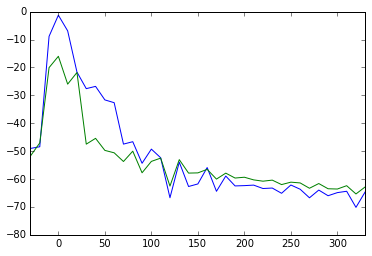

In [6]:
plt.plot(tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedAndDishRB)),tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedOnlyRB)))
plt.xlim(-30,330)
plt.ylim(-80,0)

In [7]:
dSelection=np.logical_and(dfreq>=.1,dfreq<=.2)
dMeasured=(10.**(dfreqdb/20.)*np.exp(1j*dphs*np.pi/180.))[dSelection]
fMeasured=dfreq[dSelection]
tAxisMeasured=fft.fftshift(fft.fftfreq(len(dMeasured),fMeasured[1]-fMeasured[0]))
windowMeasured=np.hamming(len(fMeasured))
#windowMeasured=signal.blackmanharris(len(fMeasured))
windowMeasured=windowMeasured/windowMeasured.mean()
gAMeasured=np.abs(fft.fftshift(fft.ifft(fft.fftshift(dMeasured*windowMeasured))))[len(dMeasured)/2]
responseMeasuredFreq=(dMeasured-gAMeasured)*(gAMeasured/(1-gAMeasured))+(1.-gAMeasured)
responseMeasured=fft.fftshift(fft.ifft(fft.fftshift(responseMeasuredFreq*windowMeasured)))

In [8]:
def convFFT(x,y):
    nx=len(x)
    xf=np.pad(x,(nx/2,nx/2),mode='constant')
    yf=np.pad(y,(nx/2,nx/2),mode='constant')
    xf=(fft.fft(fft.fftshift(xf)))
    yf=(fft.fft(fft.fftshift(yf)))
    return fft.fftshift(np.real((fft.ifft(xf*yf))))[nx/2:3*nx/2]
def dconvFFT(x,y):
    nx=len(x)
    xf=np.pad(x,(nx/2,nx/2),mode='constant')
    yf=np.pad(y,(nx/2,nx/2),mode='constant')
    xf=(fft.fft(fft.fftshift(xf)))
    yf=(fft.fft(fft.fftshift(yf)))
    return np.real(fft.fftshift(fft.ifft(xf/yf)))[nx/2:3*nx/2]

In [9]:
planeWaveFeedAndDish=np.loadtxt('../data/feedSim_500ns_pW.txt',skiprows=2)
voltageResponseFeedAndDish=np.loadtxt('../data/feedSim_500ns_o1.txt',skiprows=2)

planeWaveFeedAndDishNS=np.loadtxt('../data/feedSim_noSkirt_1000ns_pw.txt',skiprows=2)
voltageResponseFeedAndDishNS=np.loadtxt('../data/feedSim_noSkirt_1000ns_o1.txt',skiprows=2)

planeWaveFeedAndDish20Deg=np.loadtxt('../data/PW20deg_pw.txt')
voltageResponseFeedAndDish20Deg=np.loadtxt('../data/PW20deg_o1.txt')


ntFeedAndDish20Deg=len(planeWaveFeedAndDish20Deg)
dtFeedAndDish20Deg=planeWaveFeedAndDish20Deg[1,0]-planeWaveFeedAndDish20Deg[0,0]
ntFeedAndDish=len(planeWaveFeedAndDish)
dtFeedAndDish=voltageResponseFeedAndDish[1,0]-voltageResponseFeedAndDish[0,0]
dtFeedAndDishNS=voltageResponseFeedAndDishNS[1,0]-voltageResponseFeedAndDishNS[0,0]
ntFeedAndDishNS=len(planeWaveFeedAndDishNS)

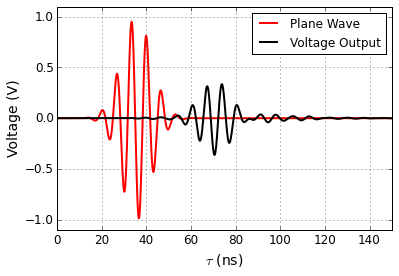

In [10]:
plt.plot(planeWaveFeedAndDish[:,0],planeWaveFeedAndDish[:,1],'-r',label='Plane Wave',lw=2)
plt.plot(voltageResponseFeedAndDish[:,0],voltageResponseFeedAndDish[:,1],'-k',label='Voltage Output',lw=2)
#plt.plot(voltageResponseFeedAndDish20Deg[:,0],voltageResponseFeedAndDish20Deg[:,1],'--k',label='Voltage Output',lw=2)


plt.xlabel('$\\tau$ (ns)',fontsize=14)
plt.ylabel('Voltage (V)',fontsize=14)
plt.legend(loc='upper right',fontsize=12)
plt.tick_params('x',labelsize=12)
plt.tick_params('y',labelsize=12)
plt.ylim(-1.1,1.1)
plt.grid()
#plt.plot(planeWaveFeed[::10,0],planeWaveFeed[::10,1],'o')
#plt.plot(voltageResponseFeed[::10,0],voltageResponseFeed[::10,1],'-o')
plt.xlim(0,150)
plt.savefig('../paper/figures/voltage_FeedAndDish.pdf',bbox_inches='tight')

In [11]:
#now look at FFT.
pwPadFeedAndDish20Deg=np.pad(planeWaveFeedAndDish20Deg[:,1],(ntFeedAndDish20Deg*.5,ntFeedAndDish20Deg*.5),mode='constant')
vrPadFeedAndDish20Deg=np.pad(voltageResponseFeedAndDish20Deg[:,1],(ntFeedAndDish20Deg*.5,ntFeedAndDish20Deg*0.5),mode='constant')
                        
fAxisPadFeedAndDish20Deg=(fft.fftfreq(len(vrPadFeedAndDish20Deg),dtFeedAndDish20Deg))
fWaveFeedAndDish20Deg=fft.fft(fft.fftshift(pwPadFeedAndDish20Deg))
fResponseFeedAndDish20Deg=fft.fft(fft.fftshift(vrPadFeedAndDish20Deg))
dfFeedAndDish20Deg=fAxisPadFeedAndDish20Deg[1]-fAxisPadFeedAndDish20Deg[0]

selectionPos=np.logical_and(fAxisPadFeedAndDish20Deg>=50./1e3,fAxisPadFeedAndDish20Deg<=250./1e3)
selectionNeg=np.logical_and(-fAxisPadFeedAndDish20Deg>=50./1e3,-fAxisPadFeedAndDish20Deg<=250./1e3)
nSelect=len(fAxisPadFeedAndDish20Deg[selectionPos])
print nSelect
windowFeedAndDish20Deg=np.hamming(nSelect)
#windowFeedAndDish=signal.blackmanharris(nSelect)
windowFeedAndDish20Deg=windowFeedAndDish20Deg/windowFeedAndDish20Deg.mean()
windowFeedAndDishFull20Deg=np.zeros(ntFeedAndDish20Deg*2)
windowFeedAndDishFull20Deg[selectionPos]=windowFeedAndDish20Deg
windowFeedAndDishFull20Deg[selectionNeg]=windowFeedAndDish20Deg
delayResponseFeedAndDish20Deg=fft.fftshift(fft.ifft(fft.fftshift((windowFeedAndDishFull20Deg*fResponseFeedAndDish20Deg/fWaveFeedAndDish20Deg)[selectionPos])))
tAxisFeedAndDish20Deg=fft.fftshift(fft.fftfreq(len(delayResponseFeedAndDish20Deg),dfFeedAndDish20Deg))

215


In [12]:
#now look at FFT.
pwPadFeedAndDish=np.pad(planeWaveFeedAndDish[:,1],(ntFeedAndDish*.5,ntFeedAndDish*.5),mode='constant')
vrPadFeedAndDish=np.pad(voltageResponseFeedAndDish[:,1],(ntFeedAndDish*.5,ntFeedAndDish*.5),mode='constant')
                        
fAxisPadFeedAndDish=(fft.fftfreq(len(vrPadFeedAndDish),dtFeedAndDish))
fWaveFeedAndDish=fft.fft(fft.fftshift(pwPadFeedAndDish))
fResponseFeedAndDish=fft.fft(fft.fftshift(vrPadFeedAndDish))
dfFeedAndDish=fAxisPadFeedAndDish[1]-fAxisPadFeedAndDish[0]

selectionPos=np.logical_and(fAxisPadFeedAndDish>=50./1e3,fAxisPadFeedAndDish<=250./1e3)
selectionNeg=np.logical_and(-fAxisPadFeedAndDish>=50./1e3,-fAxisPadFeedAndDish<=250./1e3)
nSelect=len(fAxisPadFeedAndDish[selectionPos])
print nSelect
windowFeedAndDish=np.hamming(nSelect)
#windowFeedAndDish=signal.blackmanharris(nSelect)
windowFeedAndDish=windowFeedAndDish/windowFeedAndDish.mean()
windowFeedAndDishFull=np.zeros(2*ntFeedAndDish)
windowFeedAndDishFull[selectionPos]=windowFeedAndDish
windowFeedAndDishFull[selectionNeg]=windowFeedAndDish
delayResponseFeedAndDish=fft.fftshift(fft.ifft(fft.fftshift((windowFeedAndDishFull*fResponseFeedAndDish/fWaveFeedAndDish)[selectionPos])))
tAxisFeedAndDish=fft.fftshift(fft.fftfreq(len(delayResponseFeedAndDish),dfFeedAndDish))

204


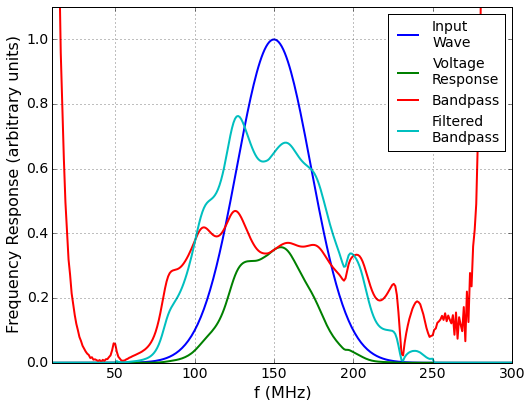

In [13]:
selection=np.logical_and(fAxisPadFeedAndDish>=.01,fAxisPadFeedAndDish<=.35)
plt.plot(fAxisPadFeedAndDish[selection]*1e3,(np.abs(fWaveFeedAndDish)/np.abs(fWaveFeedAndDish).max())[selection],label='Input\nWave',lw=2)
plt.plot(fAxisPadFeedAndDish[selection]*1e3,(np.abs(fResponseFeedAndDish)/np.abs(fWaveFeedAndDish).max())[selection],label='Voltage\nResponse',lw=2)
plt.plot(fAxisPadFeedAndDish[selection]*1e3,np.abs(fResponseFeedAndDish/fWaveFeedAndDish)[selection],label='Bandpass',lw=2)
plt.plot(fAxisPadFeedAndDish[selection]*1e3,np.abs(windowFeedAndDishFull*fResponseFeedAndDish/fWaveFeedAndDish)[selection],label='Filtered\nBandpass',lw=2)
plt.legend(loc='best',fontsize=14)
plt.xlim(10,300)
plt.ylim(0,1.1)
plt.grid()
plt.gcf().set_size_inches(3./2.*np.array([5.5,4.25]))
plt.xlabel('f (MHz)',fontsize=16)
plt.gca().tick_params('x',labelsize=14)
plt.gca().tick_params('y',labelsize=14)
plt.ylabel('Frequency Response (arbitrary units)',fontsize=16)
plt.savefig('../paper/figures/frequency_domain.pdf')

(-80, 0)

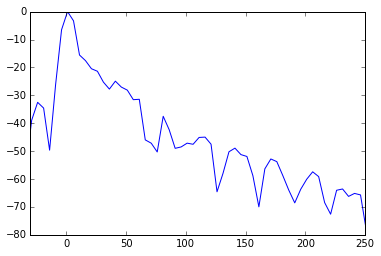

In [14]:
plt.plot(tAxisFeedAndDish-34,20.*np.log10(np.abs(delayResponseFeedAndDish)/np.abs(delayResponseFeedAndDish).max()))
plt.xlim(-30,250)
plt.ylim(-80,0)

In [15]:
#now look at FFT.
pwPadFeedAndDishNS=np.pad(planeWaveFeedAndDishNS[:,1],(ntFeedAndDishNS/2,ntFeedAndDishNS/2),mode='constant')
vrPadFeedAndDishNS=np.pad(voltageResponseFeedAndDishNS[:,1],(ntFeedAndDishNS/2,ntFeedAndDishNS/2),mode='constant')
                        
fAxisPadFeedAndDishNS=fft.fftshift((fft.fftfreq(len(vrPadFeedAndDishNS),dtFeedAndDishNS)))
dfFeedAndDishNS=fAxisPadFeedAndDishNS[1]-fAxisPadFeedAndDishNS[0]

fWaveFeedAndDishNS=fft.fftshift(fft.fft(fft.fftshift(pwPadFeedAndDishNS)))
fResponseFeedAndDishNS=fft.fftshift(fft.fft(fft.fftshift(vrPadFeedAndDishNS)))

selectionPos=np.logical_and(fAxisPadFeedAndDishNS>=50/1e3,fAxisPadFeedAndDishNS<=250/1e3)
selectionNeg=np.logical_and(-fAxisPadFeedAndDishNS>=50/1e3,-fAxisPadFeedAndDishNS<=250/1e3)
nSelect=len(fAxisPadFeedAndDishNS[selectionPos])
windowFeedAndDishNS=np.hamming(nSelect)
#windowFeedAndDishNS=signal.blackmanharris(nSelect)
windowFeedAndDishNS=windowFeedAndDishNS/windowFeedAndDishNS.mean()
windowFeedAndDishNSFull=np.zeros(2*ntFeedAndDishNS)
windowFeedAndDishNSFull[selectionPos]=windowFeedAndDishNS
windowFeedAndDishNSFull[selectionNeg]=windowFeedAndDishNS
delayResponseFeedAndDishNS=fft.fftshift(fft.ifft(fft.fftshift((windowFeedAndDishNSFull*fResponseFeedAndDishNS/fWaveFeedAndDishNS)[selectionPos])))
tAxisFeedAndDishNS=fft.fftshift(fft.fftfreq(len(delayResponseFeedAndDishNS),dfFeedAndDishNS))

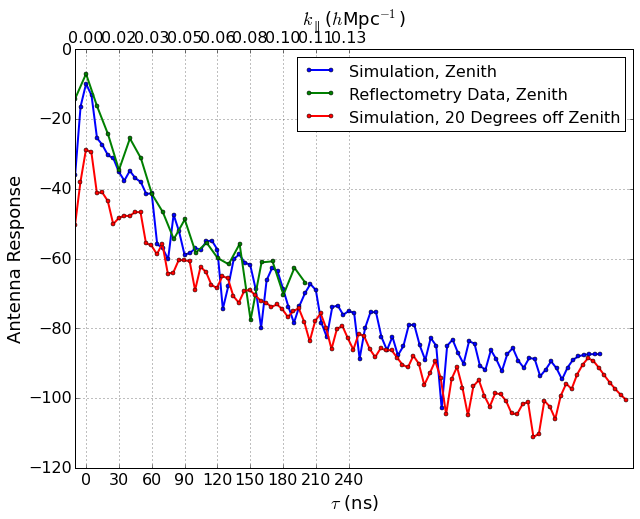

In [22]:

#use kparallel
littleh=.68
kParaFeedAndDish=cosmo.eta2kpara(tAxisFeedAndDish/1e9-35e-9,cosmo.f2z(150e6))/littleh
kParaMeasured=cosmo.eta2kpara(tAxisMeasured/1e9,cosmo.f2z(150e6))/littleh

#plt.plot(tAxisFeedAndDishNS-35,20.*np.log10(np.abs(delayResponseFeedAndDishNS)/np.abs(delayResponseFeedAndDishNS).max()),'-',label='No Skirt')
plt.plot(tAxisFeedAndDish-35,20.*np.log10(np.abs(delayResponseFeedAndDish)),'-o',label='Simulation, Zenith',markersize=4,lw=2)
plt.plot(tAxisMeasured,20.*np.log10(np.abs(responseMeasured)),'-o',label='Reflectometry Data, Zenith',markersize=4,lw=2)
plt.plot(tAxisFeedAndDish20Deg-40,20.*np.log10(np.abs(delayResponseFeedAndDish20Deg)),'-o',label='Simulation, 20 Degrees off Zenith',markersize=4,lw=2)


#plt.plot(tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedAndDishRB)),'-o',label='Reflectometry Data',markersize=2,lw=2)
#plt.plot(tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedAndDishRB)/np.abs(responseFeedAndDishRB).max()),'-o',label='Data RB',markersize=2)

plt.gca().set_xticks(np.arange(-30,260,30))
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.grid()
plt.legend(loc='best',fontsize=16)
plt.xlim(-10,500)
plt.ylim(-120,0)
ax1=plt.gca()
ax2=plt.gca().twiny()
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(ax1.get_xlim())
ticklabels=[]
for tick in ax2.get_xticks():
    ticklabels.append('%.2f'%(cosmo.eta2kpara(tick/1e9,cosmo.f2z(150e6))/littleh))

ax2.set_xticklabels(ticklabels)
ax2.tick_params('x',labelsize=16)
ax2.set_xlabel('$k_{\\parallel}$ ($h$Mpc$^{-1}$)',fontsize=18)
ax1.set_xlabel('$\\tau$ (ns)',fontsize=18)
ax1.set_ylabel('Antenna Response',fontsize=18)
plt.gcf().set_size_inches([10,7.5])


plt.savefig('../paper/figures/compareSimToData.pdf',bbox_inches='tight')

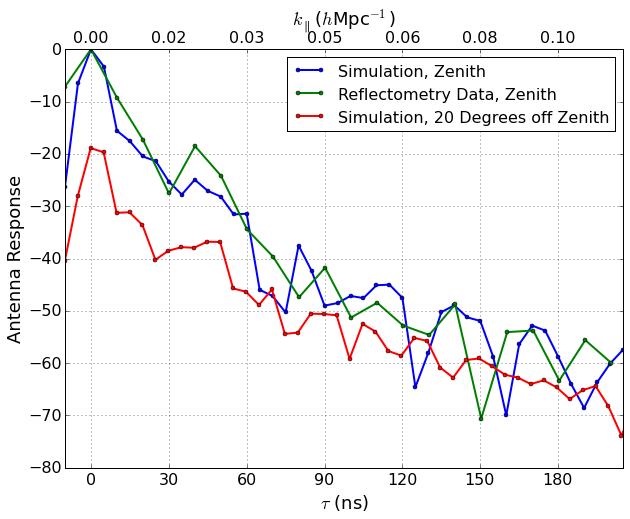

In [17]:

#use kparallel
littleh=.68
kParaFeedAndDish=cosmo.eta2kpara(tAxisFeedAndDish/1e9-35e-9,cosmo.f2z(150e6))/littleh
kParaMeasured=cosmo.eta2kpara(tAxisMeasured/1e9,cosmo.f2z(150e6))/littleh

#plt.plot(tAxisFeedAndDishNS-35,20.*np.log10(np.abs(delayResponseFeedAndDishNS)/np.abs(delayResponseFeedAndDishNS).max()),'-',label='No Skirt')
plt.plot(tAxisFeedAndDish-35,20.*np.log10(np.abs(delayResponseFeedAndDish)/np.abs(delayResponseFeedAndDish).max()),'-o',label='Simulation, Zenith',markersize=4,lw=2)
plt.plot(tAxisMeasured,20.*np.log10(np.abs(responseMeasured)/np.abs(responseMeasured).max()),'-o',label='Reflectometry Data, Zenith',markersize=4,lw=2)
plt.plot(tAxisFeedAndDish20Deg-40,20.*np.log10(np.abs(delayResponseFeedAndDish20Deg)/np.abs(delayResponseFeedAndDish).max()),'-o',label='Simulation, 20 Degrees off Zenith',markersize=4,lw=2)


#plt.plot(tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedAndDishRB)),'-o',label='Reflectometry Data',markersize=2,lw=2)
#plt.plot(tAxisFeedAndDishRB,20.*np.log10(np.abs(responseFeedAndDishRB)/np.abs(responseFeedAndDishRB).max()),'-o',label='Data RB',markersize=2)

plt.gca().set_xticks(np.arange(-30,260,30))
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.grid()
plt.legend(loc='best',fontsize=16)
plt.xlim(-10,205)
plt.ylim(-80,0)
ax1=plt.gca()
ax2=plt.gca().twiny()
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(ax1.get_xlim())
ticklabels=[]
for tick in ax2.get_xticks():
    ticklabels.append('%.2f'%(cosmo.eta2kpara(tick/1e9,cosmo.f2z(150e6))/littleh))

ax2.set_xticklabels(ticklabels)
ax2.tick_params('x',labelsize=16)
ax2.set_xlabel('$k_{\\parallel}$ ($h$Mpc$^{-1}$)',fontsize=18)
ax1.set_xlabel('$\\tau$ (ns)',fontsize=18)
ax1.set_ylabel('Antenna Response',fontsize=18)
plt.gcf().set_size_inches([10,7.5])


plt.savefig('../paper/figures/compareSimToDataNormalized.pdf',bbox_inches='tight')

In [18]:
print len(tAxisFeedAndDishRB)

1601


In [19]:
#use kparallel
import cosmology as cosmo
littleh=.68
kParaFeedAndDish=cosmo.eta2kpara(tAxisFeedAndDish/1e9-35e-9,cosmo.f2z(150e6))/littleh
kParaMeasured=cosmo.eta2kpara(tAxisMeasured/1e9,cosmo.f2z(150e6))/littleh

In [20]:
print len(kParaFeedAndDish)

204


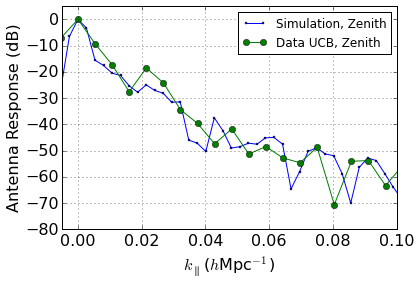

In [21]:

#plt.plot(tAxisFeedAndDishNS-35,20.*np.log10(np.abs(delayResponseFeedAndDishNS)/np.abs(delayResponseFeedAndDishNS).max()),'-',label='No Skirt')
plt.plot(kParaFeedAndDish,20.*np.log10(np.abs(delayResponseFeedAndDish)/np.abs(delayResponseFeedAndDish).max()),'-o',label='Simulation, Zenith',markersize=2)
plt.plot(kParaMeasured,20.*np.log10(np.abs(responseMeasured)/np.abs(responseMeasured).max()),'-o',label='Data UCB, Zenith')
#plt.gca().set_xticks(np.arange(-30,260,30))
ax1=plt.gca()
plt.grid()
plt.legend(loc='best')
plt.xlim(-.005,.1)
plt.ylim(-80,5)
plt.xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=16)
plt.ylabel('Antenna Response (dB)',fontsize=16)
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.savefig('../paper/figures/compareSimToDataKPara.pdf',bbox_inches='tight')